本页面为强化学习Q-Learning的toy test

参考  
https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/  
Gym API官方文档 https://www.gymlibrary.ml/content/api/  
http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/  
https://gist.github.com/foolishflyfox/e30fd8bfbb6a9cee9b1a1fa6144b209c

## The Reinforcement Learning Process
<img src='https://www.learndatasci.com/documents/14/Reinforcement-Learning-Animation.gif' style='zoom:70%'>


## Example Design: Self-Driving Cab
安装gym和一些需要的包

In [1]:
# intall OpenAI Gym interface, run following command in jupyter notebook
!pip install cmake gym scipy pygame


Actions  
There are 6 discrete deterministic actions:  

0. move south
1. move north
2. move east
3. move west
4. pickup passenger
5. drop off passenger


Passenger locations:

0. R(ed)
1. G(reen)
2. Y(ellow)
3. B(lue)
4. in taxi


Destinations:

0. R(ed)
1. G(reen)
2. Y(ellow)
3. B(lue)


Rewards
- -1 per step unless other reward is triggered.
- +20 delivering passenger.
- -10 executing “pickup” and “drop-off” actions illegally.


(350, 550, 3)
Action Space Discrete(6)
State Space Discrete(500)


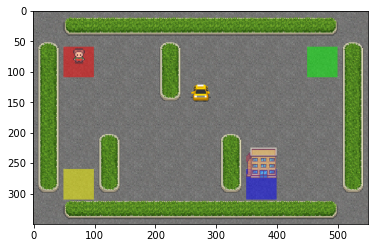

In [54]:
# load the environment
import gym
import numpy as np
env = gym.make("Taxi-v3",new_step_api=True,render_mode='rgb_array').env
# api更新参见 https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py
env.reset()
env_screen = np.array(env.render())[0]
print(env_screen.shape)
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

import matplotlib.pyplot as plt 
%matplotlib inline
plt.imshow(np.array(env_screen))

In [55]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state

State: 328


参数P中保存了状态转移之后会获得的reward，结构是$states \ \times \ actions$

This dictionary has the structure {action: [(probability, nextstate, reward, done)]}.

A few things to note:
- The 0-5 corresponds to the actions (south, north, east, west, pickup, dropoff) the taxi can perform at our current state in the illustration.
- In this env, probability is always 1.0.
- The nextstate is the state we would be in if we take the action at this index of the dict
- All the movement actions have a -1 reward and the pickup/dropoff actions have -10 reward in this particular state. If we are in a state where the taxi has a passenger and is on top of the right destination, we would see a reward of 20 at the dropoff action (5)
- done is used to tell us when we have successfully dropped off a passenger in the right location. Each successfull dropoff is the end of an episode



In [56]:
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

## Solving the environment without Reinforcement Learning
We'll create an infinite loop which runs until one passenger reaches one destination (one episode), or in other words, when the received reward is 20. The <font color = red>env.action_space.sample()</font> method automatically selects one random action from set of all possible actions.

In [57]:
env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

terminated = False

while not terminated:
    action = env.action_space.sample() # 此处action是随机的
    state, reward, terminated, truncated, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    env_screen = np.array(env.render())[0]
    frames.append(env_screen)
    #env.render()
    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 3515
Penalties incurred: 1185


In [58]:
_,info = env.reset(return_info=True)
print(info)
print(np.where(info["action_mask"] == 1))
np.where(info["action_mask"] == 1)[0]

{'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}
(array([0, 1, 2, 3]),)


array([0, 1, 2, 3])

In [59]:
print(len(frames))
print(frames[0].shape)
s = frames[0]
s.shape[:2]

3515
(350, 550, 3)


(350, 550)

In [60]:
# 动画显示参考 http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from IPython.display import clear_output
from time import sleep
import matplotlib.animation as animation
from IPython.display import display, HTML
from matplotlib import animation, rc
from IPython.display import HTML

def plot_sequence_images(image_array):
    ''' Display images sequence as an animation in jupyter notebook

    Args:
        image_array(numpy.ndarray): image_array.shape equal to (num_images, height, width, num_channels)
    '''
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[:2]
    fig = plt.figure(figsize=(ypixels / dpi, xpixels / dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array), interval=33, repeat_delay=1, repeat=False)
#     display(HTML(anim.to_html5_video()))
    #rc('animation', html='html5')
    return anim

In [61]:
anim = plot_sequence_images(frames)
rc('animation', html='html5')
anim

<Figure size 550x350 with 0 Axes>

## Enter Reinforcement Learning
Q-Learning的目标是学习一个Q-table，(state, action) combination.其中的值称为Q-value。

A Q-value for a particular state-action combination is representative of the "quality" of an action taken from that state. **Better Q-values imply better chances of getting greater rewards.**


Q-values are initialized to an arbitrary value, and as the agent exposes itself to the environment and receives different rewards by executing different actions, the Q-values are updated using the equation:
  
$Q({\small state}, {\small action}) \leftarrow (1 - \alpha) Q({\small state}, {\small action}) + \alpha \Big({\small reward} + \gamma \max_{a} Q({\small next \ state}, {\small all \ actions})\Big)$

Where:

- α (alpha) is the learning rate (0<α≤1) Just like in supervised learning settings, α is the extent to which our Q-values are being updated in every iteration.

- γ (gamma) is the discount factor (0≤γ≤1) - determines how much importance we want to give to future rewards. A high value for the discount factor (close to 1) captures the long-term effective award, whereas, a discount factor of 0 makes our agent consider only immediate reward, hence making it greedy.


The Q-table is a matrix where we have a row for every state (500) and a column for every action (6). It's first initialized to 0, and then values are updated after training. Note that the Q-table has the same dimensions as the reward table, but it has a completely different purpose.

<img src='https://storage.googleapis.com/lds-media/images/q-matrix-initialized-to-learned_gQq0BFs.width-1200.png' style='zoom:50%'>

## Summing up the Q-Learning Process
Breaking it down into steps, we get

- Initialize the Q-table by all zeros.
- Start exploring actions: For each state, select any one among all possible actions for the current state (S).
- Travel to the next state (S') as a result of that action (a).
- For all possible actions from the state (S') select the one with the highest Q-value.
- Update Q-table values using the equation.
- Set the next state as the current state.
- If goal state is reached, then end and repeat the process.


## Exploiting learned values

After enough random exploration of actions, the Q-values tend to converge serving our agent as an action-value function which it can exploit to pick the most optimal action from a given state.

There's a tradeoff between exploration (choosing a random action) and exploitation (choosing actions based on already learned Q-values). We want to prevent the action from always taking the same route, and possibly overfitting, so we'll be introducing another parameter called 
ϵ "epsilon" to cater to this during training.

Instead of just selecting the best learned Q-value action, we'll sometimes favor exploring the action space further. Lower epsilon value results in episodes with more penalties (on average) which is obvious because we are exploring and making random decisions.

## Implementing Q-learning in python
### Training the Agent

In [62]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

We can now create the training algorithm that will update this Q-table as the agent explores the environment over thousands of episodes.

In the first part of while not done, we decide whether to pick a random action or to exploit the already computed Q-values. This is done simply by using the epsilon value and comparing it to the random.uniform(0, 1) function, which returns an arbitrary number between 0 and 1.

We execute the chosen action in the environment to obtain the next_state and the reward from performing the action. After that, we calculate the maximum Q-value for the actions corresponding to the next_state, and with that, we can easily update our Q-value to the new_q_value:

In [63]:
%%time
'''training the agent'''

import random
from IPython.display import clear_output

#hyperparameter
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# for plotting metrics
all_epochs = []
all_penalties = []
episodes=100


epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.01


for episode in range(1, episodes):
    print(episode)
    state, info = env.reset(return_info=True)
    
    epochs, penalties, reward=0,0,0
    terminated =False
    while not terminated:
        if random.uniform(0,1) < epsilon: # 这一步叫做epsilon策略
            # explore action space
            action = env.action_space.sample()
        else:
            # exploit learned values
            action = np.argmax(q_table[state, np.where(info["action_mask"] == 1)[0]])
            #int(action)
           # action = np.argmax(q_table[state, np.where(info["action_mask"] == 1)[0]]])
            
#         next_state, reward, done, info = env.step(action)
        next_state, reward, terminated, truncated, info = env.step(action)
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        
        new_value = (1-alpha)*old_value + alpha*(reward+gamma*next_max)
        q_table[state, action] = new_value
        
        if reward == -10:
            penalties += 1
            
        state = next_state
        epochs += 1 
        
        if episode%100 ==0:
            clear_output(wait=True)
            print(f"Episode: {i}")
    #Reduce epsilon (because we want to reduce the number of exploration as time passes)
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        
print("Training finished.\n")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Training finished.

CPU times: user 11min 17s, sys: 29.6 s, total: 11min 46s
Wall time: 11min 39s


In [64]:
q_table

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -2.06937244,  -2.00957746,  -2.2477313 ,  -1.98602154,
         -1.83119047, -10.61485856],
       [ -1.00311785,  -0.60680652,  -1.60296224,  -0.70805097,
         -0.75515523,  -6.24844215],
       ...,
       [ -1.19033586,  -1.4234836 ,  -1.35642966,  -1.13259146,
         -9.87046735, -10.3930616 ],
       [ -1.10674639,  -1.83677461,  -1.07560589,  -1.26815308,
         -9.46194012,  -9.15641021],
       [  3.1356757 ,   1.70361183,   2.31701685,   8.31841896,
         -5.77180523,  -5.67112152]])

### Evaluating the agent
We don't need to explore actions any further, so now the next action is always selected using the best Q-value:


In [65]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 50

for i in range(episodes):
    print(i)
    state, info = env.reset(return_info=True)
    epochs, penalties, reward = 0, 0, 0
    
    terminated = False
    
    while not terminated:
        print(state)
        action = np.argmax(q_table[state, np.where(info["action_mask"] == 1)[0]])
        #state, reward, done, info = env.step(action)
        print(action)
        state, reward, terminated, _, info = env.step(action)
        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

0
452
1
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
35

352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352
2
352


KeyboardInterrupt: 

再开一次小车

In [14]:
env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

terminated = False

while not terminated:
    
    action = np.argmax(q_table[state])
    #action = env.action_space.sample() # 此处action是随机的
    print(state,action)
    state, reward, terminated, truncated, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    env_screen = np.array(env.render())[0]
    frames.append(env_screen)
    #env.render()
    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

anim_new = plot_sequence_images(frames)
anim_new

242 3
202 2
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 

222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 2
242 3
222 

KeyboardInterrupt: 

### Hyperparameters and optimizations
The values of `alpha`, `gamma`, and `epsilon` were mostly based on intuition and some "hit and trial", but there are better ways to come up with good values.

Ideally, all three should decrease over time because as the agent continues to learn, it actually builds up more resilient priors;


- alpha: (the learning rate) should decrease as you continue to gain a larger and larger knowledge base.

- gamma: as you get closer and closer to the deadline, your preference for near-term reward should increase, as you won't be around long enough to get the long-term reward, which means your gamma should decrease.

- epsilon: as we develop our strategy, we have less need of exploration and more exploitation to get more utility from our policy, so as trials increase, epsilon should decrease.

### Tuning the hyperparameters

A simple way to programmatically come up with the best set of values of the hyperparameter is to create a comprehensive search function (similar to grid search) that selects the parameters that would result in best reward/time_steps ratio. The reason for reward/time_steps is that we want to choose parameters which enable us to get the maximum reward as fast as possible. We may want to track the number of penalties corresponding to the hyperparameter value combination as well because this can also be a deciding factor (we don't want our smart agent to violate rules at the cost of reaching faster). A more fancy way to get the right combination of hyperparameter values would be to use Genetic Algorithms.

https://www.kaggle.com/code/angps95/intro-to-reinforcement-learning-with-openai-gym/notebook 

https://github.com/bmaxdk/OpenAI-Gym-Taxi-v3

https://fakabbir.github.io/reinforcement-learning/docs/opentaxi-v2/

https://github.com/ElliotVilhelm/QLearning

https://www.kaggle.com/code/angps95/intro-to-reinforcement-learning-with-openai-gym/notebook

https://rubikscode.net/2019/06/24/introduction-to-q-learning-with-python-and-open-ai-gym/

https://adventuresinmachinelearning.com/reinforcement-learning-tutorial-python-keras/

https://zhuanlan.zhihu.com/p/26689541

https://www.simplilearn.com/tutorials/machine-learning-tutorial/reinforcement-learning

https://www.zhihu.com/question/333671830


<img src='https://storage.googleapis.com/lds-media/images/q-matrix-initialized-to-learned_gQq0BFs.width-1200.png' style='zoom:50%'>